In [77]:

import matplotlib.pyplot as plt
from math import floor
import cv2
import numpy as np


In [78]:
def show_image(image, rotated_image):
    fig, axes = plt.subplots(1, 2)

    # Hiển thị hình ảnh thứ nhất trên Axes đầu tiên
    axes[0].imshow(image)
    axes[0].axis('off')

    # Hiển thị hình ảnh thứ hai trên Axes thứ hai
    axes[1].imshow(rotated_image)
    axes[1].axis('off')

    # Hiển thị cả Figure
    plt.show()

In [153]:
# Đường dẫn đến file hình ảnh
import cv2

# Đọc hình ảnh và chuyển đổi thành mảng NumPy
img = cv2.imread('test2.jpg').astype(np.float64)

In [159]:
img.shape

(403, 387, 3)

> ## Bilinear interpolation rotation

In [154]:
import numpy as np
from PIL import Image

def bilinear_interpolation_rotation(image, angle):
    # Convert image to numpy array
    image_array = np.array(image)

    # Convert angle to radians
    angle_rad = np.radians(-angle)  # Negative angle for right rotation

    # Calculate image center
    center_x = image_array.shape[1] / 2
    center_y = image_array.shape[0] / 2

    # Calculate new image dimensions to fit rotated image
    new_width = int(np.ceil(np.abs(image_array.shape[1] * np.cos(angle_rad)) + np.abs(image_array.shape[0] * np.sin(angle_rad))))
    new_height = int(np.ceil(np.abs(image_array.shape[1] * np.sin(angle_rad)) + np.abs(image_array.shape[0] * np.cos(angle_rad))))

    # Create an empty array for the rotated image
    rotated_image_array = np.zeros((new_height, new_width, image_array.shape[2]), dtype=np.uint8)

    # Calculate scale factors
    scale_x = (image_array.shape[1]) / (new_width)
    scale_y = (image_array.shape[0]) / (new_height)

    for k in range(3):
        for i in range(new_height):
            for j in range(new_width):
                # Calculate original coordinates
                x = (j + 0.5) * scale_x - 0.5 - center_x
                y = (i + 0.5) * scale_y - 0.5 - center_y

                # Apply rotation
                x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad) + center_x
                y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad) + center_y

                # Check if the rotated coordinates are within the original image boundaries
                if x_rot < 0 or x_rot >= image_array.shape[1] or y_rot < 0 or y_rot >= image_array.shape[0]:
                    # Set black color for out-of-bound pixels
                    rotated_image_array[i, j, k] = 0
                else:
                    # Calculate indices
                    x_int = int(x_rot)
                    y_int = int(y_rot)

                    x_diff = x_rot - x_int
                    y_diff = y_rot - y_int
                    if x_int + 1 >= image_array.shape[1] or  y_int + 1 >= image_array.shape[0]:
                        # Set black color for out-of-bound pixels
                        rotated_image_array[i, j, k] = 0
                        continue
                    # Perform bilinear interpolation
                    a = image_array[y_int, x_int, k]
                    b = image_array[y_int, x_int + 1, k]
                    c = image_array[y_int + 1, x_int, k]
                    d = image_array[y_int + 1, x_int + 1, k]

                    pixel = a * (1 - x_diff) * (1 - y_diff) + b * (x_diff) * (1 - y_diff) + c * (1 - x_diff) * (y_diff) + d * x_diff * y_diff

                    # Assign interpolated value to corresponding pixel in rotated image
                    rotated_image_array[i, j, k] = pixel.astype(np.uint8)

    # Convert the rotated image array
    # rotated_image = Image.fromarray(rotated_image_array)

    return rotated_image_array


rotated_image_by_bilinear = bilinear_interpolation_rotation(img, 45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


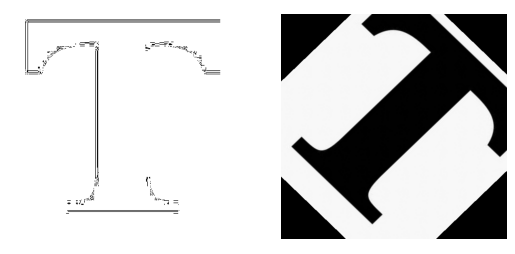

In [156]:
show_image(img, rotated_image_by_bilinear)

> ## Bicubic interpolation rotation

In [157]:

def W(x):
    '''Weight function that returns weight for each distance point
    Parameters:
    x (float): Distance from destination point

    Returns:
    float: Weight
    '''
    a = -0.5
    pos_x = abs(x)
    if -1 <= abs(x) <= 1:
        return ((a+2)*(pos_x**3)) - ((a+3)*(pos_x**2)) + 1
    elif 1 < abs(x) < 2 or -2 < x < -1:
        return ((a * (pos_x**3)) - (5*a*(pos_x**2)) + (8 * a * pos_x) - 4*a)
    else:
        return 0

import numpy as np
from PIL import Image

def bicubic_interpolation(img, angle):
    '''Bicubic interpolation method to rotate an image
    Parameters:
    img (numpy.ndarray): Input image
    angle (float): Rotation angle in degrees

    Returns:
    numpy.ndarray: Rotated image
    '''
    # Convert angle to radians
    theta = np.radians(angle)

    # Calculate rotation matrix
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    # Calculate center coordinates
    center = np.array(img.shape[:2][::-1]) / 2  # Invert the shape and reverse the order

    # Create output image
    output = np.zeros_like(img)

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            # Apply inverse rotation transformation
            rotated_coordinates = np.dot(rotation_matrix, np.array([i, j]) - center) + center

            # Apply bicubic interpolation
            x = rotated_coordinates[0]
            y = rotated_coordinates[1]
            xi = int(x)
            yi = int(y)
            u = x - xi
            v = y - yi

            out = 0
            for n in range(-1, 3):
                for m in range(-1, 3):
                    if ((xi + n < 0) or (xi + n >= img.shape[1]) or (yi + m < 0) or (yi + m >= img.shape[0])):
                        continue
                    try:
                        out += (img[min(img.shape[0], xi+n),min(yi+m, img.shape[1])] * (W(u - n) * W(v - m)))
                    except:
                        continue
                        

            output[i, j] = np.clip(out, 0, 255)

    return output.astype(np.uint8)



# Xoay hình ảnh 45 độ sang phải sử dụng bicubic interpolation
rotated_image_bicubic = bicubic_interpolation(img, 45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


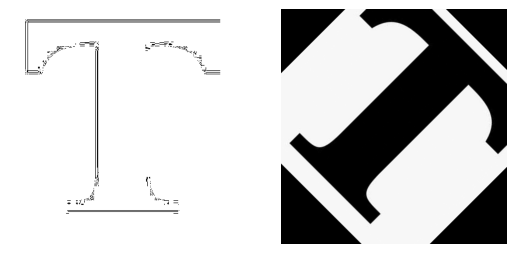

In [158]:
show_image(img, rotated_image_bicubic)

### 1. Bilinear Interpolation
Bilinear interpolation is performed using linear interpolation first in one direction, and then again in the other direction. Bilinear interpolation uses values of only the 4 nearest pixels, located in diagonal directions from a given pixel, in order to find the appropriate color intensity values of that pixel ([Wikipedia](https://en.wikipedia.org/wiki/Bilinear_interpolation)).

!["Bilinear Interpolation"](https://user-images.githubusercontent.com/26917380/101096980-9c35a680-35d5-11eb-9a48-c7325c8a0e9c.png)
!["Bilinear Algorithm"](https://user-images.githubusercontent.com/26917380/101096977-9b047980-35d5-11eb-9756-8063cf5fc2be.jpeg)

### 2. Bicubic Interpolation 
In image processing, bicubic interpolation is often chosen over bilinear or nearest-neighbor interpolation in image resampling, when speed is not an issue. In contrast to bilinear interpolation, which only takes 4 pixels (2×2) into account, bicubic interpolation considers 16 pixels (4×4)([Wikipedia](https://en.wikipedia.org/wiki/Bicubic_interpolation#:~:text=In%20mathematics%2C%20bicubic%20interpolation%20is,interpolation%20or%20nearest%2Dneighbor%20interpolation.))
!["Bicubic Interpolation"](https://user-images.githubusercontent.com/26917380/101096971-99d34c80-35d5-11eb-861c-b8c88ab5866d.jpeg)
![ "Bicubic convolution formula"](https://user-images.githubusercontent.com/26917380/101096982-9c35a680-35d5-11eb-8ebc-9b2ccc0b4bf4.png)